# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [4]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


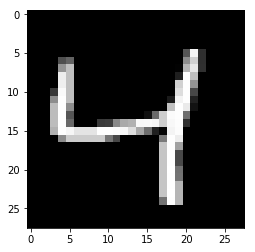

In [6]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [7]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='inputs')
targets_ = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (2, 2), padding='same', activation= tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size= (2, 2),strides=[2, 2], padding= 'same')
# Now 14x14x16
conv2 =  tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x8
conv3 =  tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded =  tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
conv6 =  tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss =  tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [8]:
sess = tf.Session()

In [9]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6698
Epoch: 1/20... Training loss: 0.6576
Epoch: 1/20... Training loss: 0.6427
Epoch: 1/20... Training loss: 0.6258
Epoch: 1/20... Training loss: 0.6070
Epoch: 1/20... Training loss: 0.5860
Epoch: 1/20... Training loss: 0.5674
Epoch: 1/20... Training loss: 0.5472
Epoch: 1/20... Training loss: 0.5326
Epoch: 1/20... Training loss: 0.5370
Epoch: 1/20... Training loss: 0.5298
Epoch: 1/20... Training loss: 0.5253
Epoch: 1/20... Training loss: 0.5270
Epoch: 1/20... Training loss: 0.5461
Epoch: 1/20... Training loss: 0.5399
Epoch: 1/20... Training loss: 0.5179
Epoch: 1/20... Training loss: 0.5056
Epoch: 1/20... Training loss: 0.5013
Epoch: 1/20... Training loss: 0.4918
Epoch: 1/20... Training loss: 0.4968
Epoch: 1/20... Training loss: 0.4897
Epoch: 1/20... Training loss: 0.4826
Epoch: 1/20... Training loss: 0.4791
Epoch: 1/20... Training loss: 0.4710
Epoch: 1/20... Training loss: 0.4638
Epoch: 1/20... Training loss: 0.4611
Epoch: 1/20... Training loss: 0.4498
E

Epoch: 1/20... Training loss: 0.1621
Epoch: 1/20... Training loss: 0.1637
Epoch: 1/20... Training loss: 0.1616
Epoch: 1/20... Training loss: 0.1624
Epoch: 1/20... Training loss: 0.1605
Epoch: 1/20... Training loss: 0.1678
Epoch: 1/20... Training loss: 0.1609
Epoch: 1/20... Training loss: 0.1597
Epoch: 1/20... Training loss: 0.1593
Epoch: 1/20... Training loss: 0.1624
Epoch: 1/20... Training loss: 0.1609
Epoch: 1/20... Training loss: 0.1558
Epoch: 1/20... Training loss: 0.1538
Epoch: 1/20... Training loss: 0.1587
Epoch: 1/20... Training loss: 0.1617
Epoch: 1/20... Training loss: 0.1513
Epoch: 1/20... Training loss: 0.1632
Epoch: 1/20... Training loss: 0.1576
Epoch: 1/20... Training loss: 0.1549
Epoch: 1/20... Training loss: 0.1587
Epoch: 1/20... Training loss: 0.1551
Epoch: 1/20... Training loss: 0.1597
Epoch: 1/20... Training loss: 0.1610
Epoch: 1/20... Training loss: 0.1573
Epoch: 1/20... Training loss: 0.1570
Epoch: 1/20... Training loss: 0.1599
Epoch: 1/20... Training loss: 0.1523
E

Epoch: 2/20... Training loss: 0.1393
Epoch: 2/20... Training loss: 0.1403
Epoch: 2/20... Training loss: 0.1381
Epoch: 2/20... Training loss: 0.1410
Epoch: 2/20... Training loss: 0.1406
Epoch: 2/20... Training loss: 0.1398
Epoch: 2/20... Training loss: 0.1422
Epoch: 2/20... Training loss: 0.1389
Epoch: 2/20... Training loss: 0.1365
Epoch: 2/20... Training loss: 0.1447
Epoch: 2/20... Training loss: 0.1349
Epoch: 2/20... Training loss: 0.1322
Epoch: 2/20... Training loss: 0.1405
Epoch: 2/20... Training loss: 0.1434
Epoch: 2/20... Training loss: 0.1383
Epoch: 2/20... Training loss: 0.1402
Epoch: 2/20... Training loss: 0.1380
Epoch: 2/20... Training loss: 0.1391
Epoch: 2/20... Training loss: 0.1354
Epoch: 2/20... Training loss: 0.1411
Epoch: 2/20... Training loss: 0.1356
Epoch: 2/20... Training loss: 0.1389
Epoch: 2/20... Training loss: 0.1415
Epoch: 2/20... Training loss: 0.1412
Epoch: 2/20... Training loss: 0.1383
Epoch: 2/20... Training loss: 0.1414
Epoch: 2/20... Training loss: 0.1384
E

Epoch: 3/20... Training loss: 0.1283
Epoch: 3/20... Training loss: 0.1309
Epoch: 3/20... Training loss: 0.1295
Epoch: 3/20... Training loss: 0.1292
Epoch: 3/20... Training loss: 0.1299
Epoch: 3/20... Training loss: 0.1339
Epoch: 3/20... Training loss: 0.1253
Epoch: 3/20... Training loss: 0.1308
Epoch: 3/20... Training loss: 0.1263
Epoch: 3/20... Training loss: 0.1265
Epoch: 3/20... Training loss: 0.1329
Epoch: 3/20... Training loss: 0.1353
Epoch: 3/20... Training loss: 0.1294
Epoch: 3/20... Training loss: 0.1277
Epoch: 3/20... Training loss: 0.1290
Epoch: 3/20... Training loss: 0.1321
Epoch: 3/20... Training loss: 0.1236
Epoch: 3/20... Training loss: 0.1260
Epoch: 3/20... Training loss: 0.1315
Epoch: 3/20... Training loss: 0.1257
Epoch: 3/20... Training loss: 0.1269
Epoch: 3/20... Training loss: 0.1263
Epoch: 3/20... Training loss: 0.1318
Epoch: 3/20... Training loss: 0.1292
Epoch: 3/20... Training loss: 0.1238
Epoch: 3/20... Training loss: 0.1273
Epoch: 3/20... Training loss: 0.1338
E

Epoch: 3/20... Training loss: 0.1258
Epoch: 3/20... Training loss: 0.1235
Epoch: 3/20... Training loss: 0.1303
Epoch: 3/20... Training loss: 0.1267
Epoch: 3/20... Training loss: 0.1227
Epoch: 3/20... Training loss: 0.1293
Epoch: 3/20... Training loss: 0.1263
Epoch: 3/20... Training loss: 0.1278
Epoch: 3/20... Training loss: 0.1287
Epoch: 3/20... Training loss: 0.1208
Epoch: 3/20... Training loss: 0.1236
Epoch: 3/20... Training loss: 0.1267
Epoch: 4/20... Training loss: 0.1339
Epoch: 4/20... Training loss: 0.1236
Epoch: 4/20... Training loss: 0.1295
Epoch: 4/20... Training loss: 0.1239
Epoch: 4/20... Training loss: 0.1217
Epoch: 4/20... Training loss: 0.1247
Epoch: 4/20... Training loss: 0.1250
Epoch: 4/20... Training loss: 0.1257
Epoch: 4/20... Training loss: 0.1304
Epoch: 4/20... Training loss: 0.1209
Epoch: 4/20... Training loss: 0.1215
Epoch: 4/20... Training loss: 0.1232
Epoch: 4/20... Training loss: 0.1255
Epoch: 4/20... Training loss: 0.1291
Epoch: 4/20... Training loss: 0.1243
E

Epoch: 4/20... Training loss: 0.1177
Epoch: 4/20... Training loss: 0.1204
Epoch: 4/20... Training loss: 0.1223
Epoch: 4/20... Training loss: 0.1242
Epoch: 4/20... Training loss: 0.1220
Epoch: 4/20... Training loss: 0.1199
Epoch: 4/20... Training loss: 0.1233
Epoch: 4/20... Training loss: 0.1219
Epoch: 4/20... Training loss: 0.1261
Epoch: 4/20... Training loss: 0.1253
Epoch: 4/20... Training loss: 0.1202
Epoch: 4/20... Training loss: 0.1205
Epoch: 4/20... Training loss: 0.1214
Epoch: 4/20... Training loss: 0.1201
Epoch: 4/20... Training loss: 0.1189
Epoch: 4/20... Training loss: 0.1224
Epoch: 4/20... Training loss: 0.1224
Epoch: 4/20... Training loss: 0.1235
Epoch: 4/20... Training loss: 0.1244
Epoch: 4/20... Training loss: 0.1212
Epoch: 4/20... Training loss: 0.1168
Epoch: 4/20... Training loss: 0.1218
Epoch: 4/20... Training loss: 0.1239
Epoch: 4/20... Training loss: 0.1190
Epoch: 4/20... Training loss: 0.1214
Epoch: 4/20... Training loss: 0.1243
Epoch: 4/20... Training loss: 0.1206
E

Epoch: 5/20... Training loss: 0.1172
Epoch: 5/20... Training loss: 0.1160
Epoch: 5/20... Training loss: 0.1212
Epoch: 5/20... Training loss: 0.1235
Epoch: 5/20... Training loss: 0.1179
Epoch: 5/20... Training loss: 0.1134
Epoch: 5/20... Training loss: 0.1194
Epoch: 5/20... Training loss: 0.1175
Epoch: 5/20... Training loss: 0.1171
Epoch: 5/20... Training loss: 0.1165
Epoch: 5/20... Training loss: 0.1191
Epoch: 5/20... Training loss: 0.1215
Epoch: 5/20... Training loss: 0.1175
Epoch: 5/20... Training loss: 0.1197
Epoch: 5/20... Training loss: 0.1190
Epoch: 5/20... Training loss: 0.1142
Epoch: 5/20... Training loss: 0.1190
Epoch: 5/20... Training loss: 0.1182
Epoch: 5/20... Training loss: 0.1212
Epoch: 5/20... Training loss: 0.1231
Epoch: 5/20... Training loss: 0.1221
Epoch: 5/20... Training loss: 0.1175
Epoch: 5/20... Training loss: 0.1152
Epoch: 5/20... Training loss: 0.1175
Epoch: 5/20... Training loss: 0.1195
Epoch: 5/20... Training loss: 0.1188
Epoch: 5/20... Training loss: 0.1247
E

Epoch: 6/20... Training loss: 0.1179
Epoch: 6/20... Training loss: 0.1161
Epoch: 6/20... Training loss: 0.1166
Epoch: 6/20... Training loss: 0.1226
Epoch: 6/20... Training loss: 0.1092
Epoch: 6/20... Training loss: 0.1135
Epoch: 6/20... Training loss: 0.1165
Epoch: 6/20... Training loss: 0.1176
Epoch: 6/20... Training loss: 0.1110
Epoch: 6/20... Training loss: 0.1169
Epoch: 6/20... Training loss: 0.1170
Epoch: 6/20... Training loss: 0.1205
Epoch: 6/20... Training loss: 0.1174
Epoch: 6/20... Training loss: 0.1196
Epoch: 6/20... Training loss: 0.1188
Epoch: 6/20... Training loss: 0.1187
Epoch: 6/20... Training loss: 0.1184
Epoch: 6/20... Training loss: 0.1130
Epoch: 6/20... Training loss: 0.1136
Epoch: 6/20... Training loss: 0.1138
Epoch: 6/20... Training loss: 0.1148
Epoch: 6/20... Training loss: 0.1183
Epoch: 6/20... Training loss: 0.1203
Epoch: 6/20... Training loss: 0.1173
Epoch: 6/20... Training loss: 0.1188
Epoch: 6/20... Training loss: 0.1182
Epoch: 6/20... Training loss: 0.1150
E

KeyboardInterrupt: 

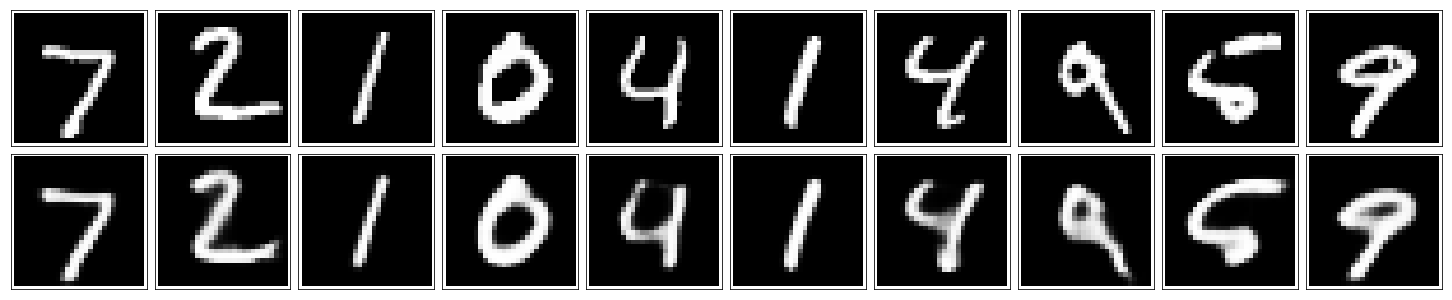

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [19]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [ ]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 =  tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 =  tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded =  tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 =  tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 =  tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 =  tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 =  tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 =  tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits =  tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)